# Libraries and Installations

In [3]:
!pip install sagemaker-experiments
!pip install s3fs
!pip install matplotlib
!pip install seaborn
!pip install 'shap==0.25.1'
!pip install smdebug

In [13]:
!pip install shap # 'shap==0.25.1'
#!conda install 'shap==0.25.1'

In [4]:
from io import StringIO
import numpy as np
import os
import pandas as pd
import boto3
import time
import s3fs
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import re
import shap
from scipy import stats
import copy

In [5]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

from sagemaker.sklearn.estimator import SKLearn
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig,CollectionConfig
from sagemaker.estimator import Estimator
from sagemaker.session import s3_input
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.session import Session

from smdebug.trials  import create_trial

[2021-05-11 05:46:25.636 ip-172-16-30-65:23324 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


# Configs

In [6]:
now = datetime.now()

current_time = now.strftime("%Y-%m-%d--%H-%M-%S")
print("current_time:",current_time)

sagemaker_session = sagemaker.Session()

role = get_execution_role()

bucket = '1905-assignment2-sm'
prefix = 'Scikit-pre-model-Inference-Pipelines'

train_data = 's3://1905-assignment2-sm/housing/imput-datasets/train_data_without_header.csv'
test_data = 's3://1905-assignment2-sm/housing/imput-datasets/test_data_without_header.csv'

FRAMEWORK_VERSION = "0.23-1"
script_path = 'sklearn_pipeline.py'
dependency_path ='dependencies.py'

base_job_name = f"Builtin-XGB-algo-{current_time}"

output_data_prefix = f'housing/datasets/output/{base_job_name}'
data_output_path = f's3://{bucket}/{output_data_prefix}'

debug_prefix = f'housing/jobs/debug/{base_job_name}'
debug_path = f's3://{bucket}/{debug_prefix}'

experiment_name_prefix = "builtin-xgboost-track13"

current_time: 2021-05-11--05-46-25


In [7]:
train_data

's3://1905-assignment2-sm/housing/imput-datasets/train_data_without_header.csv'

In [8]:
role

'arn:aws:iam::752400441523:role/Sagemaker_Access'

# Batch transform

## Fit the train data

In [305]:
sklearn_preprocessor = SKLearn(
    entry_point = script_path,
    role = role,
    framework_version = FRAMEWORK_VERSION,
    train_instance_type =  "ml.m5.xlarge", #"local" ,
    train_use_spot_instance = True,
    train_max_run = 600,
   # train_max_wait = 1200,
    dependencies = [dependency_path],
    sagemaker_session = sagemaker_session)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.


In [306]:
role

'arn:aws:iam::752400441523:role/Sagemaker_Access'

In [307]:
sklearn_preprocessor.fit(
    inputs={'train':train_data},
    job_name=base_job_name)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: Builtin-XGB-algo-2021-05-10--10-02-29


2021-05-10 12:26:56 Starting - Starting the training job...
2021-05-10 12:26:58 Starting - Launching requested ML instancesProfilerReport-1620649616: InProgress
.........
2021-05-10 12:28:43 Starting - Preparing the instances for training......
2021-05-10 12:29:43 Downloading - Downloading input data
2021-05-10 12:29:43 Training - Downloading the training image......
2021-05-10 12:30:55 Training - Training image download completed. Training in progress..2021-05-10 12:30:55,818 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-05-10 12:30:55,822 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-10 12:30:55,834 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-05-10 12:30:56,176 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-10 12:30:56,188 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-10

## Transform the training data

In [10]:
transformer = sklearn_preprocessor.transformer(
    instance_count=1,
    instance_type='ml.m5.xlarge',
    assemble_with = 'Line',
    accept = 'text/csv',
    output_path=data_output_path)

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2021-04-29-07-09-26-986


In [11]:
transformer.transform(
    data=train_data,
    content_type="text/csv",
    job_name=base_job_name+'-train')

print("Waiting for transform job:" + transformer.latest_transform_job.job_name)
transformer.wait()

INFO:sagemaker:Creating transform job with name: Builtin-XGB-algo-2021-04-29--07-05-13-train


...........................
.2021-04-29 07:13:52,028 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2021-04-29 07:13:52,030 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2021-04-29 07:13:52,031 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

2021-04-29 07:13:52,028 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2021-04-29 07:13:52,030 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2021-04-29 07:13:52,031 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicor

In [12]:
preprocessed_train_data = transformer.output_path

In [13]:
preprocessed_train_data

's3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-04-29--07-05-13'

## Transform the test data

In [14]:
transformer.transform(
    data=test_data,
    content_type="text/csv",
    job_name=base_job_name+"-test")

print("Waiting for transform job:" + transformer.latest_transform_job.job_name)
transformer.wait()

INFO:sagemaker:Creating transform job with name: Builtin-XGB-algo-2021-04-29--07-05-13-test


............................2021-04-29 07:18:39,155 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2021-04-29 07:18:39,158 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2021-04-29 07:18:39,158 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
  

In [15]:
preprocessed_test_data = transformer.output_path

In [16]:
f'{output_data_prefix}'

'housing/datasets/output/Builtin-XGB-algo-2021-04-29--07-05-13'

## Upload processed data to s3

In [17]:
client = boto3.client('s3')
obj = client.get_object(Bucket=bucket, Key = f'{output_data_prefix}/train_data_without_header.csv.out')
body = obj['Body']
csv_string = body.read().decode('utf-8')
processed_train_data = pd.read_csv(StringIO(csv_string))

In [18]:
train_file = 'processed_train_data.csv'
processed_train_data.to_csv(train_file,index=False,header=False)
with open(train_file,'rb') as data:
    boto3.Session().resource('s3').Bucket(bucket).upload_fileobj(data,os.path.join(output_data_prefix,'processed-train-data.csv'))

In [19]:
obj = client.get_object(Bucket=bucket, Key = f'{output_data_prefix}/test_data_without_header.csv.out')
body = obj['Body']
csv_string = body.read().decode('utf-8')
processed_test_data = pd.read_csv(StringIO(csv_string))

test_file = 'processed_test_data.csv'
processed_test_data.to_csv(test_file,index=False,header=False)
with open(test_file,'rb') as data:
    boto3.Session().resource('s3').Bucket(bucket).upload_fileobj(data,os.path.join(output_data_prefix,'processed-test-data.csv'))

## Real time Prediction using endpoint

In [20]:
from sagemaker.model import Model
from sagemaker.pipeline import PipelineModel
import boto3
from time import gmtime, strftime
from sagemaker.estimator import Estimator
from sagemaker import PipelineModel

timestamp_prefix = current_time

scikit_learn_inferencee_model = sklearn_preprocessor.create_model()
scikit_learn_inferencee_model.env = {"SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT":"text/csv"}
model_containers = [scikit_learn_inferencee_model]

model_name = 'inference-pipeline-' + current_time
endpoint_name = 'inference-pipeline-ep-' + current_time

sm_model = PipelineModel(
            name=model_name,
            role=role,
            models=model_containers)

predictor = sm_model.deploy(initial_instance_count=1,
                           instance_type='ml.m5.xlarge',
                           endpoint_name=endpoint_name,
                           #data_capture_config=data_capture_config
                           )

from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

payload = "-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY"

predictor = Predictor(
        endpoint_name = endpoint_name,
        sagemaker_session = sagemaker_session,
        serializer = CSVSerializer(),
        deserializer = JSONDeserializer(),
    )


In [38]:
print(predictor.predict(data=payload))

{'instances': [{'features': [-1.3358644914093034, 1.0625114171921215, 0.9843617822955569, -0.7963234446647113, -0.9664904061190807, -0.9606541571538452, -0.9683302007899453, 2.3372729061643134, 0.6152810290729377, -0.07388883558315307, -1.073845989834207, 0.0, 0.0, 0.0, 1.0, 0.0]}]}


In [39]:
#Delete the endpoint
sm_client = sagemaker_session.boto_session.client('sagemaker')
sm_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '215f8680-8a28-4feb-9008-2fead898ae7a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '215f8680-8a28-4feb-9008-2fead898ae7a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 29 Apr 2021 07:52:29 GMT'},
  'RetryAttempts': 0}}

# Train, Track and Debug

In [9]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = get_execution_role()
region = "us-east-1"

In [10]:
container = get_image_uri(region, "xgboost",repo_version="0.90-2")

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [11]:
container

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'

In [12]:
save_interval = 2

In [13]:
prefix

'Scikit-pre-model-Inference-Pipelines'

In [14]:
content_type = "text/csv"
#train_input = s3_input(f"s3://{bucket}/{output_data_prefix}/processed-train/processed_train_data.csv",content_type='csv')
#validation_input = s3_input(f"s3://{bucket}/{output_data_prefix}/processed-test/processed_test_data.csv",content_type='csv')
train_input = s3_input(f"s3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-04-29--07-05-13/processed-train-data.csv",content_type='csv')
                       #s3://1905-assignment2-sm/housing/imput-datasets/train_data_without_header.csv",content_type='csv')
validation_input = s3_input(f"s3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-04-29--07-05-13/processed-test-data.csv",content_type='csv')
                            #s3://1905-assignment2-sm/housing/imput-datasets/test_data_without_header.csv",content_type='csv')

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [15]:
train_input

<sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7ffb264999e8>

In [16]:
train_df = pd.read_csv("s3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-04-29--07-05-13/processed-train-data.csv")
#(f"s3://{bucket}/{output_data_prefix}/processed_train_data.csv")
train_df.head()

,358500.0,-1.3308659273736732,1.0531251317946908,-0.6070897683036017,2.0208102069451725,1.3411817591876816,0.8416448031203787,1.6458948847855055,2.32479358344881,0.32165837830261435,-0.14313788487103407,-0.9276488585077218,0.0,0.0.1,0.0.2,1.0,0.0.3
0,352100.0,-1.340863,1.048432,1.859660,-0.530419,-0.822409,-0.809812,-0.836586,1.777381,1.128541,-0.035559,-1.345015,0.0,0.0,0.0,1.0,0.0
1,341300.0,-1.345862,1.048432,1.859660,-0.617846,-0.716119,-0.756064,-0.728090,0.930937,0.156037,-0.075071,-0.472465,0.0,0.0,0.0,1.0,0.0
2,226700.0,-1.350860,1.043739,1.063934,-0.037568,0.299541,-0.194309,0.243203,-0.937134,-0.443510,-0.156026,0.731576,0.0,0.0,0.0,1.0,0.0
3,261100.0,-1.345862,1.043739,1.859660,0.412702,0.398745,0.104774,0.550607,-0.092525,-0.177251,-0.133439,-0.238176,0.0,0.0,0.0,1.0,0.0
4,281500.0,-1.350860,1.048432,1.859660,-0.197473,-0.246081,-0.450913,-0.255360,-0.348456,0.022315,-0.119236,-0.271804,0.0,0.0,0.0,1.0,0.0


# Pre-processing Tracker

In [17]:
with Tracker.create(display_name="Pre-Processing",sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({
        "Num_Imputer" : "SimpleImputer",
        "Num_Norm" : "StandardScaler",
        "Cat_Norm" : "SimpleImputer",
        "Cat_Convert" : "OneHotEncoder",
        "No_of_rows" : str(len(train_df))
    })
    tracker.log_input(name="xgboost-track",media_type="s3/uri",value=f"s3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-04-29--07-05-13/processed-train-data.csv")
                      #s3://{bucket}/{output_data_prefix}//s3://1905-assignment2-sm/housing/imput-datasets/train_data_without_header.csv")

## Create Experiment

In [18]:
xgboost_experiment = Experiment.create(
    experiment_name = f"{experiment_name_prefix}--{int(time.time())}",
    description = "xgboost-track",
    sagemaker_boto_client=sm)
print(xgboost_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7ffb26c0c400>,experiment_name='builtin-xgboost-track13--1620712009',description='xgboost-track',tags=None,experiment_arn='arn:aws:sagemaker:us-east-1:752400441523:experiment/builtin-xgboost-track13--1620712009',response_metadata={'RequestId': 'b1c7b969-9722-46d0-96d5-b2803eaf420b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'b1c7b969-9722-46d0-96d5-b2803eaf420b', 'content-type': 'application/x-amz-json-1.1', 'content-length': '107', 'date': 'Tue, 11 May 2021 05:46:49 GMT'}, 'RetryAttempts': 0})


In [19]:
trial_name_map = {}

In [20]:
trial_component = tracker.trial_component

In [21]:
debug_path

's3://1905-assignment2-sm/housing/jobs/debug/Builtin-XGB-algo-2021-05-11--05-46-25'

## Train

In [22]:
for i,eta in enumerate([0.2,0.9]):
    for j,max_depth in enumerate([2,4]):
        base_name = f"xbg-eta-{str(eta).replace('.','-')}-max-depth-{str(max_depth).replace('.','-')}"
        time_val = f"time-{int(time.time())}"
        trial_name = base_name + "-" + time_val
        xgb_trial = Trial.create(
            trial_name=trial_name,
            experiment_name = xgboost_experiment.experiment_name,
            sagemaker_boto_client=sm,)
        trial_name_map[(eta,max_depth)] = trial_name
        
        #associate preprocessing trial component with current trial
        xgb_trial.add_trial_component(trial_component)
        
        xgboost_estimator = Estimator(
            role=role,
            base_job_name=trial_name,
            train_instance_count=1,
            train_instance_type= 'ml.m5.xlarge',
            image_uri=container,
            hyperparameters={
                "max_depth": max_depth, #str(max_depth), [str(2),str(4)],
                "eta": float(eta), #[str(0.2),str(0.9)], #str(eta),
                "gamma": float(4), #["2","3"], #"4",
                "min_child_weight":float(6), #"6",
                "subsample":float(0.8), #"0.7",
                "silent":0,
                "eval_metric":"rmse",
                "objective":"reg:linear",
                "num_round": 6, #"51",
            },
            enable_sagemaker_metrics=True,
            #train_use_spot_instances=True,
            #train_max_run=600,
            #train_max_wait=1200,
        
            debugger_hook_config=DebuggerHookConfig(
            s3_output_path=debug_path,
            collection_configs=[
                    CollectionConfig(
                        name="metrics",
                        parameters={
                            "save_interval":str(save_interval)
                        }
                    ),
                    CollectionConfig(
                        name="feature_importance",
                        parameters={
                            "save_interval":str(save_interval)
                        }
                    ),
                    CollectionConfig(
                        name="full_shap",
                        parameters={
                            "save_interval":str(save_interval)
                        }
                    ),
                    CollectionConfig(
                        name="average_shap",
                        parameters={
                            "save_interval":str(save_interval)
                        }
                    ),
                ],
            ),

            rules=[
                Rule.sagemaker(
                    rule_configs.loss_not_decreasing(),
                    rule_parameters={
                        "collection_names" : "metrics",
                        "num_steps" : "4", #str(save_interval*2),
                    },
                ),
            ],
        )
    
        xgb_training_job_name = "xgb-training-job-{}".format(int(time.time()))
    
        xgboost_estimator.fit(
            {"train":train_input,"validation":validation_input},
            experiment_config={
                "TrialName":xgb_trial.trial_name,
                "TrialComponentDisplayName":"Training",
            },
            wait=False
        )
    
        time.sleep(4)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: xbg-eta-0-2-max-depth-2-time-1620712014-2021-05-11-05-46-54-432
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uri

## Configure Debuggers in best models again

In [ ]:
#Find the best model and rerun using the parameters obtained from trial component analysis

base_name = f"xbg-eta-{str(0.9).replace('.','-')}-max-depth-{str(2).replace('.','-')}-bestmodel"
time_val = f"time-{int(time.time())}"
trial_name = base_name + "-" + time_val
xgb_trial = Trial.create(
    trial_name=trial_name,
    experiment_name = xgboost_experiment.experiment_name,
    sagemaker_boto_client=sm,)
trial_name_map[(eta,max_depth)] = trial_name

#associate preprocessing trial component with current trial
xgb_trial.add_trial_component(trial_component)

xgboost_estimator = Estimator(
    role=role,
    base_job_name=trial_name,
    train_instance_count=1,
    train_instance_type= 'ml.m5.xlarge',
    image_uri=container,
    hyperparameters={
        "max_depth": 2,
        "eta": float(0.9),
        "gamma": float(4),
        "min_child_weight":float(6),
        "subsample":float(0.8), 
        "silent":0,
        "eval_metric":"rmse",
        "objective":"reg:linear",
        "num_round": 2, 
    },
    enable_sagemaker_metrics=True,
    #train_use_spot_instances=True,
    #train_max_run=600,
    #train_max_wait=1200,

    debugger_hook_config=DebuggerHookConfig(
    s3_output_path=debug_path,
    collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval":str(save_interval)
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval":str(save_interval)
                }
            ),
            CollectionConfig(
                name="full_shap",
                parameters={
                    "save_interval":str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval":str(save_interval)
                }
            ),
        ],
    ),

    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names" : "metrics",
                "num_steps" : "4", #str(save_interval*2),
            },
        ),
        Rule.sagemaker(rule_configs.overfit()),
    ],
)

xgb_training_job_name = "xgb-training-job-{}".format(int(time.time()))

xgboost_estimator.fit(
    {"train":train_input,"validation":validation_input},
    experiment_config={
        "TrialName":xgb_trial.trial_name,
        "TrialComponentDisplayName":"Training",
    },
    wait=False
)

time.sleep(4)

## List Train Jobs

In [23]:
search_expression = {
    "Filters":[
        {
            "Name":"DisplayName",
            "Operator":"Equals",
            "Value":"Training",
        }
    ],
}

In [24]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess,sm),
    experiment_name=xgboost_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.validation:rmse.max",
    sort_order="Descending",
    metric_names=['validation:rmse'],
    parameter_names=['max_depth','eta','silent','gamma']
)

In [25]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,eta,gamma,max_depth,silent,validation:rmse - Min,validation:rmse - Max,validation:rmse - Avg,...,train - MediaType,train - Value,validation - MediaType,validation - Value,SageMaker.DebugHookOutput - MediaType,SageMaker.DebugHookOutput - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments
0,xbg-eta-0-2-max-depth-2-time-1620712014-2021-0...,Training,arn:aws:sagemaker:us-east-1:752400441523:train...,0.2,4.0,2.0,0.0,97663.8,196486.0,138290.966667,...,csv,s3://1905-assignment2-sm/housing/datasets/outp...,csv,s3://1905-assignment2-sm/housing/datasets/outp...,None,s3://1905-assignment2-sm/housing/jobs/debug/Bu...,None,s3://sagemaker-us-east-1-752400441523/xbg-eta-...,[xbg-eta-0-2-max-depth-2-time-1620712014],[builtin-xgboost-track13--1620712009]
1,xbg-eta-0-2-max-depth-4-time-1620712018-2021-0...,Training,arn:aws:sagemaker:us-east-1:752400441523:train...,0.2,4.0,4.0,0.0,89314.4,194884.0,133017.733333,...,csv,s3://1905-assignment2-sm/housing/datasets/outp...,csv,s3://1905-assignment2-sm/housing/datasets/outp...,None,s3://1905-assignment2-sm/housing/jobs/debug/Bu...,None,s3://sagemaker-us-east-1-752400441523/xbg-eta-...,[xbg-eta-0-2-max-depth-4-time-1620712018],[builtin-xgboost-track13--1620712009]
2,xbg-eta-0-9-max-depth-2-time-1620712023-2021-0...,Training,arn:aws:sagemaker:us-east-1:752400441523:train...,0.9,4.0,2.0,0.0,67683.4,86315.3,73502.500000,...,csv,s3://1905-assignment2-sm/housing/datasets/outp...,csv,s3://1905-assignment2-sm/housing/datasets/outp...,None,s3://1905-assignment2-sm/housing/jobs/debug/Bu...,None,s3://sagemaker-us-east-1-752400441523/xbg-eta-...,[xbg-eta-0-9-max-depth-2-time-1620712023],[builtin-xgboost-track13--1620712009]
3,xbg-eta-0-9-max-depth-4-time-1620712028-2021-0...,Training,arn:aws:sagemaker:us-east-1:752400441523:train...,0.9,4.0,4.0,0.0,58073.3,75132.9,62971.316667,...,csv,s3://1905-assignment2-sm/housing/datasets/outp...,csv,s3://1905-assignment2-sm/housing/datasets/outp...,None,s3://1905-assignment2-sm/housing/jobs/debug/Bu...,None,s3://sagemaker-us-east-1-752400441523/xbg-eta-...,[xbg-eta-0-9-max-depth-4-time-1620712028],[builtin-xgboost-track13--1620712009]


## Best Training Job

In [26]:
result_df =trial_component_analytics.dataframe(force_refresh=True).sort_values(['validation:rmse - StdDev'],ascending=True)

In [27]:
best_trial_component_name = result_df.iloc[0]['TrialComponentName']
best_trial_component = TrialComponent.load(best_trial_component_name)

In [28]:
print(best_trial_component.parameters['max_depth'])
print(best_trial_component.parameters['eta'])
print(best_trial_component.parameters['min_child_weight'])

4.0
0.9
6.0


In [29]:
best_trial_component.parameters

{'SageMaker.ImageUri': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3',
 'SageMaker.InstanceCount': 1.0,
 'SageMaker.InstanceType': 'ml.m5.xlarge',
 'SageMaker.VolumeSizeInGB': 30.0,
 'eta': 0.9,
 'eval_metric': 'rmse',
 'gamma': 4.0,
 'max_depth': 4.0,
 'min_child_weight': 6.0,
 'num_round': 6.0,
 'objective': 'reg:linear',
 'silent': 0.0,
 'subsample': 0.8}

In [30]:
best_trial_component.source.source_arn.split("/")[-1]

'xbg-eta-0-9-max-depth-4-time-1620712028-2021-05-11-05-47-08-465'

## Lineage

In [31]:
trial_name_map

{(0.2, 2): 'xbg-eta-0-2-max-depth-2-time-1620712014',
 (0.2, 4): 'xbg-eta-0-2-max-depth-4-time-1620712018',
 (0.9, 2): 'xbg-eta-0-9-max-depth-2-time-1620712023',
 (0.9, 4): 'xbg-eta-0-9-max-depth-4-time-1620712028'}

In [32]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess,sm),
    search_expression={
        "Filters":[{
            "Name":"Parents.TrialName",
            "Operator":"Equals",
            "Value":trial_name_map[(0.9, 4)]
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

lineage_table.dataframe()

,TrialComponentName,DisplayName,Cat_Convert,Cat_Norm,No_of_rows,Num_Imputer,Num_Norm,xgboost-track - MediaType,xgboost-track - Value,Trials,...,validation:rmse - Last,validation:rmse - Count,train - MediaType,train - Value,validation - MediaType,validation - Value,SageMaker.DebugHookOutput - MediaType,SageMaker.DebugHookOutput - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value
0,TrialComponent-2021-05-11-054647-cdou,Pre-Processing,OneHotEncoder,SimpleImputer,16449,SimpleImputer,StandardScaler,s3/uri,s3://1905-assignment2-sm/housing/datasets/outp...,"[xbg-eta-0-9-max-depth-4-time-1620712028, xbg-...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,xbg-eta-0-9-max-depth-4-time-1620712028-2021-0...,Training,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[xbg-eta-0-9-max-depth-4-time-1620712028],...,58073.3,6.0,csv,s3://1905-assignment2-sm/housing/datasets/outp...,csv,s3://1905-assignment2-sm/housing/datasets/outp...,NaN,s3://1905-assignment2-sm/housing/jobs/debug/Bu...,NaN,s3://sagemaker-us-east-1-752400441523/xbg-eta-...


# Get the Best Model

In [1]:
from sagemaker.model import Model
from sagemaker.pipeline import PipelineModel
import boto3
from time import gmtime, strftime
from sagemaker.estimator import Estimator
from sagemaker import PipelineModel

timestamp_prefix = current_time

#scikit_learn_inferencee_model = sklearn_preprocessor.create_model()
#scikit_learn_inferencee_model.env = {"SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT":"text/csv"}
algo_estimator = Estimator.attach(best_trial_component.source.source_arn.split("/")[-1])
best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})

model_containers = [best_algo_model]

NameError: name 'current_time' is not defined

# Explain Best Model

## Load Best Model Tensors

In [37]:
algo_estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:752400441523:processing-job/xbg-eta-0-9-max-depth-4-ti-lossnotdecreasing-9cc74bc3',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2021, 5, 11, 5, 51, 53, 584000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'ProfilerReport-1620712028',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:752400441523:processing-job/xbg-eta-0-9-max-depth-4-ti-profilerreport-1620712028-abc56e4c',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2021, 5, 11, 5, 51, 33, 49000, tzinfo=tzlocal())}]

In [38]:
algo_estimator.latest_job_debugger_artifacts_path()

In [39]:
best_model_track_path = os.path.join(
    debug_path,
    best_trial_component.source.source_arn.split("/")[-1],
    "debug-output")
best_model_track_path

's3://1905-assignment2-sm/housing/jobs/debug/Builtin-XGB-algo-2021-05-11--05-46-25/xbg-eta-0-9-max-depth-4-time-1620712028-2021-05-11-05-47-08-465/debug-output'

In [40]:
#trial = create_trial(best_model_track_path)
trial = create_trial("s3://1905-assignment2-sm/housing/jobs/debug/Builtin-XGB-algo-2021-05-10--10-02-29/xbg-eta-0-9-max-depth-4-time-1620646931-2021-05-10-11-42-11-901/debug-output")

[2021-05-11 05:51:58.019 ip-172-16-30-65:23324 INFO s3_trial.py:42] Loading trial debug-output at path s3://1905-assignment2-sm/housing/jobs/debug/Builtin-XGB-algo-2021-05-10--10-02-29/xbg-eta-0-9-max-depth-4-time-1620646931-2021-05-10-11-42-11-901/debug-output


In [41]:
trial.tensor_names()

[2021-05-11 05:51:59.591 ip-172-16-30-65:23324 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-05-11 05:52:00.614 ip-172-16-30-65:23324 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f2',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f12',
 'feature_importance/cover/f2',
 'feature_importance/cover/f4',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f12',
 'feature_importance/gain/f2',
 'feature_importance/gain/f4',
 'feature_importance/gain/f7',
 'feature_importance/gain/f8',
 'feature_importance/gain/f9',
 'feature_importance/total_cover/f0',
 'feature_importance/total_cover/f1',
 'feature_importance/total_cover/f12',
 'feature_importance/total_cover/f2',
 'feature_importance/total_cover/f4',
 'feature_importance/total_cover/f7',
 'feature_importance/total_cover/f8',
 'feature_importance/total_cover/f9',
 'feature_importance/total_gain/f0',
 'feature_importance/total_gain/f1',
 'feature_importance/total_gain/f12',
 'feature_importance/total_gain/f2',
 'feature_importance/total_gain/f4',
 'feature_importance/total_gain/f7',
 'feature_importance/total_gain/f8',
 'feature_importance/total_gain/f9',
 'feature_importance/weight/f0',
 'feature_importance/weight/f1',
 'feature_importance/weight/f12',
 'feature_importance/weight/f2',
 'feature_importance/weight/f4',
 'feature_importance/weight/f7',
 'feature_importance/weight/f8',
 'feature_importance/weight/f9',
 'full_shap/f0',
 'full_shap/f1',
 'full_shap/f10',
 'full_shap/f11',
 'full_shap/f12',
 'full_shap/f13',
 'full_shap/f14',
 'full_shap/f15',
 'full_shap/f2',
 'full_shap/f3',
 'full_shap/f4',
 'full_shap/f5',
 'full_shap/f6',
 'full_shap/f7',
 'full_shap/f8',
 'full_shap/f9',
 'train-rmse',
 'validation-rmse']

In [42]:
trial.tensor("train-rmse").steps()

[0, 2, 4]

In [43]:
trial.tensor("validation-rmse").values()

{0: array([75132.890625]), 2: array([60990.46875]), 4: array([58335.773438])}

In [44]:
trial.tensor("validation-rmse").steps()

[0, 2, 4]

In [45]:
{i for i in trial.tensor_names() if "average_shap" in i}

{'average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f2',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9'}

In [46]:
feature_names = [
    'longitude',
    'latitude',
    'housing_mdeian_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'rooms_per_household',
    'population_per_household',
    'bedrooms_per_room',
    '<1H OCEAN',
    'INLAND',
    'ISLAND',
    'NEAR BAY',
    'NEAR OCEAN'
]

In [47]:
def get_data(trial,tname):
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial,collection_name,regex='.*',figsize=(8,6)):
    fig,ax = plt.subplots(figsize=figsize)
    sns.despine()
    
    print(collection_name)
    if(collection_name == "metrics"):
        tensors = trial.collection(collection_name).tensor_names
    else:
        tensors = {i for i in trial.tensor_names() if collection_name in i}
     
    for tensor_name in sorted(tensors):
        if re.match(regex,tensor_name):
            steps, data = get_data(trial,tensor_name)
            if(len(tensors)) ==2:
                label=tensor_name
            else:
                label= tensor_name+"-"+feature_names[int(tensor_name.split("/")[-1].split("f")[1])]
            ax.plot(
                steps,
                data,
                label=label)
    
    ax.legend(loc='center left',bbox_to_anchor=(1,0.5))
    ax.set_xlabel('Iteration')

In [48]:
def plot_feature_importance(trial,importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES=["Weight","gain","cover","total_gain","total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"(importance_type) is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

## Metrics - VIZ

metrics


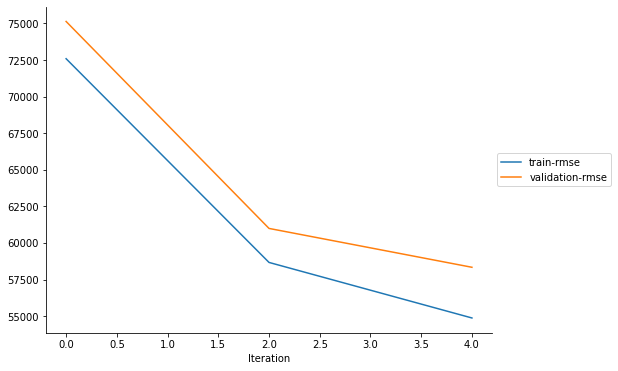

In [49]:
plot_collection(trial,"metrics")

## Cover - VIZ

feature_importance


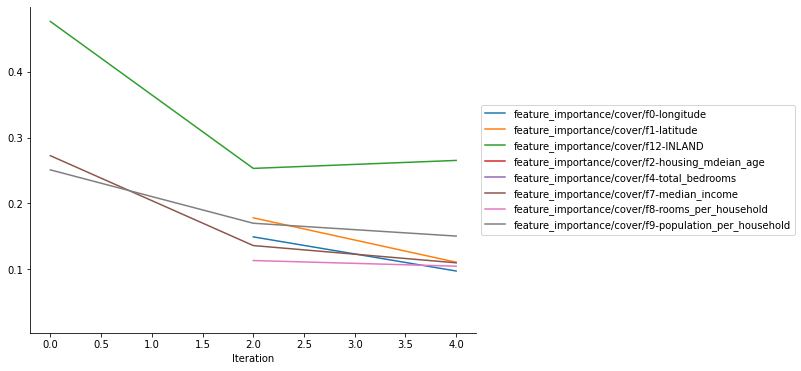

In [50]:
plot_feature_importance(trial,importance_type="cover")

## Average SHAP - VIZ

average_shap


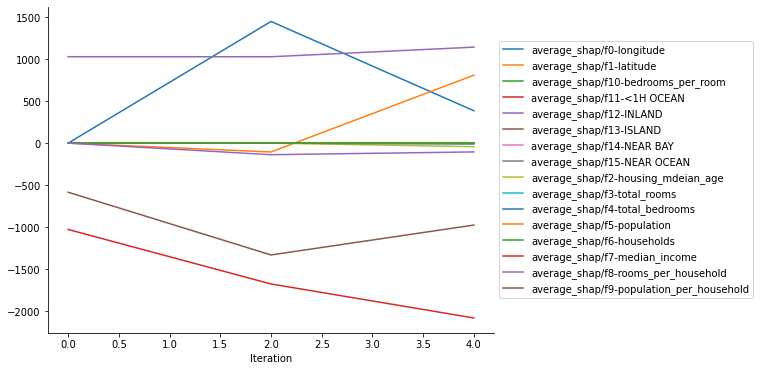

In [51]:
plot_collection(trial,"average_shap")

## Global Explanations

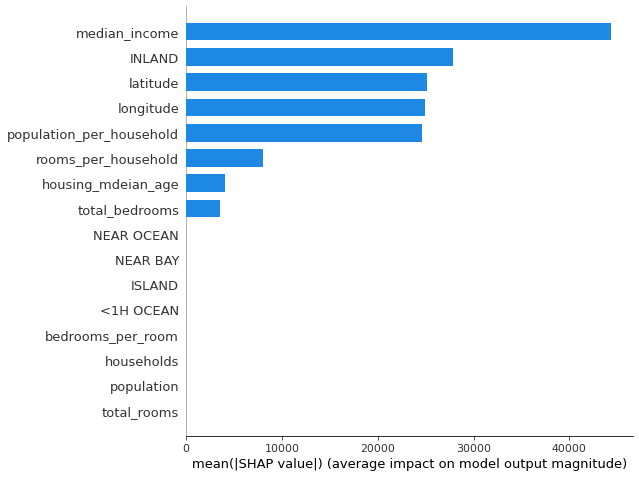

In [52]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:,:-1]
shap_base_value = shap_values[0,-1]
shap.summary_plot(shap_no_base,plot_type='bar',feature_names=feature_names)

In [53]:
f"{data_output_path}"

's3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-05-11--05-46-25'

## Local explanations

In [54]:
data = pd.read_csv(f"s3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-04-29--07-05-13/processed-train-data.csv",header=None)
data.columns = ["median_house_value"]+ feature_names

In [55]:
data.head()

,median_house_value,longitude,latitude,housing_mdeian_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,358500.0,-1.330866,1.053125,-0.607090,2.020810,1.341182,0.841645,1.645895,2.324794,0.321658,-0.143138,-0.927649,0.0,0.0,0.0,1.0,0.0
1,352100.0,-1.340863,1.048432,1.859660,-0.530419,-0.822409,-0.809812,-0.836586,1.777381,1.128541,-0.035559,-1.345015,0.0,0.0,0.0,1.0,0.0
2,341300.0,-1.345862,1.048432,1.859660,-0.617846,-0.716119,-0.756064,-0.728090,0.930937,0.156037,-0.075071,-0.472465,0.0,0.0,0.0,1.0,0.0
3,226700.0,-1.350860,1.043739,1.063934,-0.037568,0.299541,-0.194309,0.243203,-0.937134,-0.443510,-0.156026,0.731576,0.0,0.0,0.0,1.0,0.0
4,261100.0,-1.345862,1.043739,1.859660,0.412702,0.398745,0.104774,0.550607,-0.092525,-0.177251,-0.133439,-0.238176,0.0,0.0,0.0,1.0,0.0


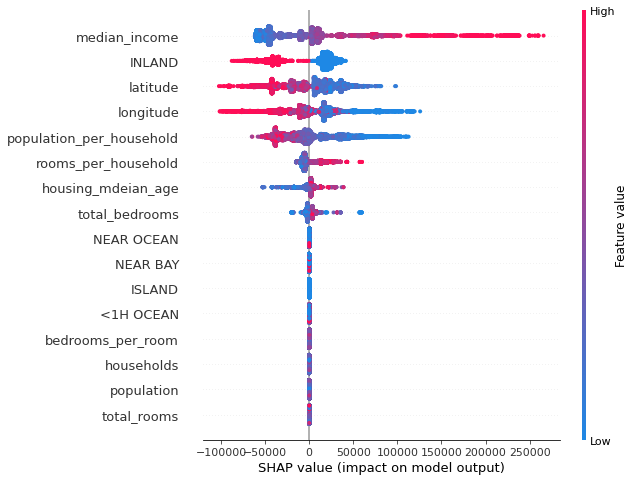

In [56]:
shap.summary_plot(shap_no_base,data[['longitude',
    'latitude',
    'housing_mdeian_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'rooms_per_household',
    'population_per_household',
    'bedrooms_per_room',
    '<1H OCEAN',
    'INLAND',
    'ISLAND',
    'NEAR BAY',
    'NEAR OCEAN']],feature_names=feature_names)

## Local explanations, for a record

In [57]:
shap.initjs()

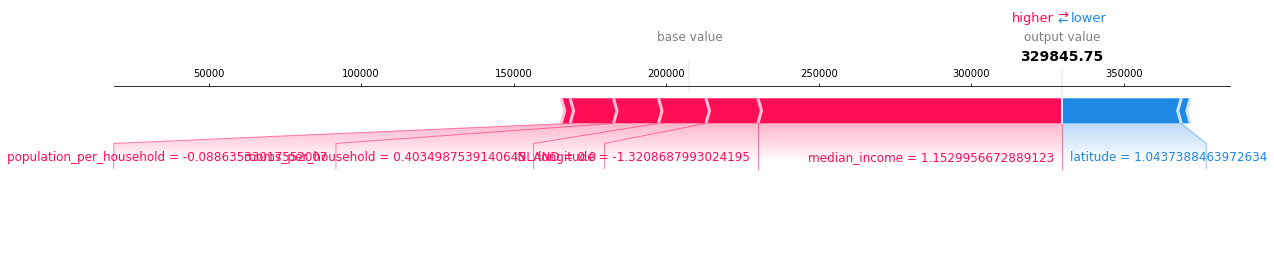

In [61]:
shap.force_plot(shap_base_value,shap_no_base[100,:],
               data[['longitude',
    'latitude',
    'housing_mdeian_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'rooms_per_household',
    'population_per_household',
    'bedrooms_per_room',
    '<1H OCEAN',
    'INLAND',
    'ISLAND',
    'NEAR BAY',
    'NEAR OCEAN']].iloc[100,:],link="identity",matplotlib=True,
                #text_rotation=90,
                figsize=(20,3))

## Stacked force plot

In [59]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100,N_ROWS)
sampled_indices=np.random.randint(N_ROWS,size=N_SAMPLES)

In [60]:
shap.force_plot(shap_base_value,
                shap_no_base[sampled_indices,:],
               data[['longitude',
    'latitude',
    'housing_mdeian_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'rooms_per_household',
    'population_per_household',
    'bedrooms_per_room',
    '<1H OCEAN',
    'INLAND',
    'ISLAND',
    'NEAR BAY',
    'NEAR OCEAN']].iloc[sampled_indices,:],
            link='identity')

## Outlier

In [62]:
N_OUTLIERS = 3

shap_sum = np.sum(shap_no_base,axis=1)
z_scores = stats.zscore(shap_sum)
outlier_indices = (np.argpartition(z_scores,-N_OUTLIERS)
                  [-N_OUTLIERS:]).tolist()
outlier_indices += (np.argpartition(z_scores,N_OUTLIERS)
                   [:N_OUTLIERS]).tolist()

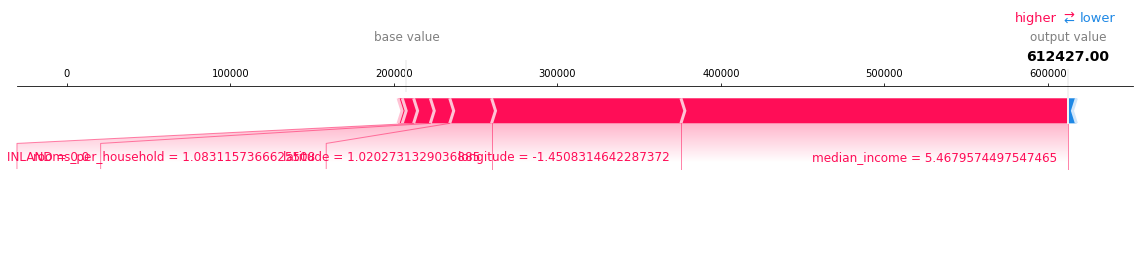

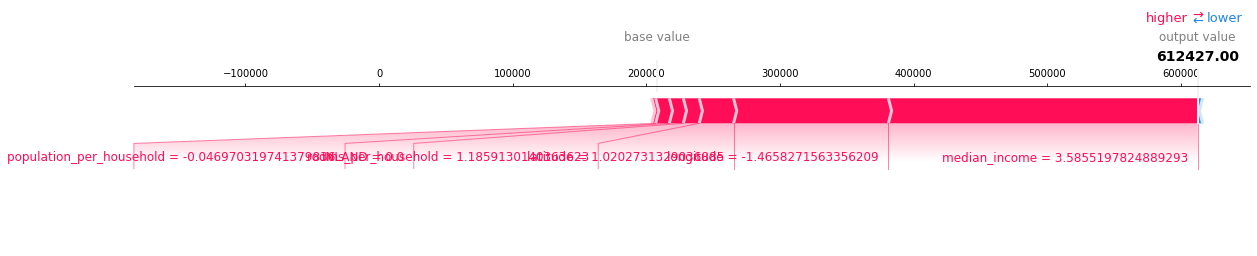

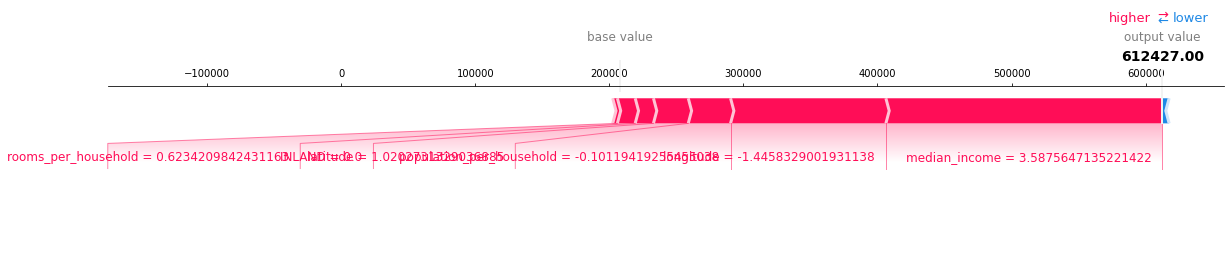

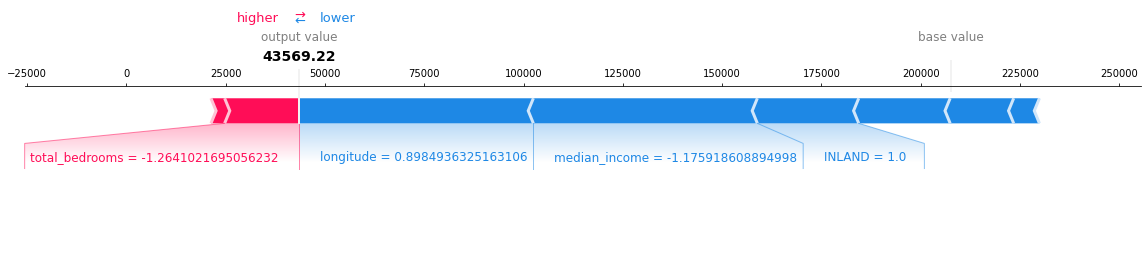

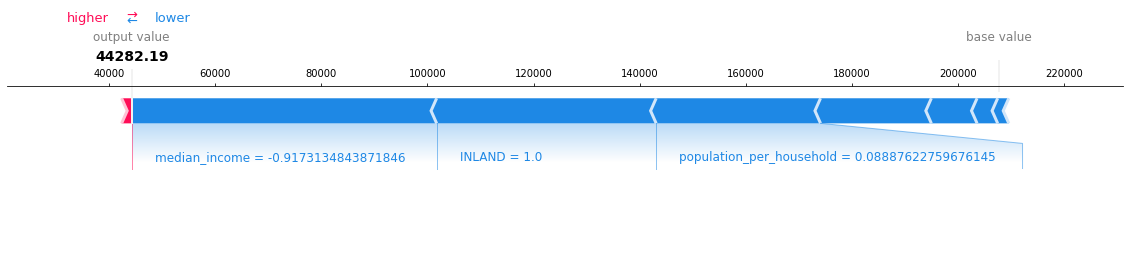

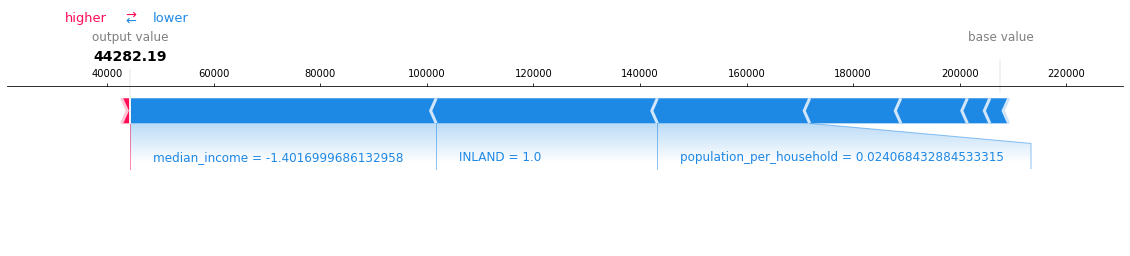

In [64]:
for fig_index,outlier_index in enumerate(outlier_indices,start=1):
    shap.force_plot(shap_base_value,
                   shap_no_base[outlier_index,:],
                   data[['longitude',
    'latitude',
    'housing_mdeian_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'rooms_per_household',
    'population_per_household',
    'bedrooms_per_room',
    '<1H OCEAN',
    'INLAND',
    'ISLAND',
    'NEAR BAY',
    'NEAR OCEAN']].iloc[outlier_index,:],
                   matplotlib=True,
                   link='identity',
                    #text_rotation=90,
                    figsize=(20,3))
    

# Deploy in endpoint

In [65]:
best_trial_component.source.source_arn.split("/")[-1]

'xbg-eta-0-9-max-depth-4-time-1620712028-2021-05-11-05-47-08-465'

In [66]:
f'{base_job_name}-Endpoint'

'Builtin-XGB-algo-2021-05-11--05-46-25-Endpoint'

In [67]:
bucket = '1905-assignment2-sm'
prefix = 'ModelMonitor'

data_capture_prefix = '{}/datacapture'.format(prefix)
s3_capture_upload_path = 's3://{}/{}'.format(bucket,data_capture_prefix)

In [68]:
from sagemaker.model_monitor import DataCaptureConfig

In [69]:
data_capture_config = DataCaptureConfig(enable_capture=True,
                                       sampling_percentage = 100,
                                       destination_s3_uri = s3_capture_upload_path)

In [70]:
model_name = f'{base_job_name}-Model'
endpoint_name = f'{base_job_name}-Endpoint'
endpoint_name

'Builtin-XGB-algo-2021-05-11--05-46-25-Endpoint'

In [322]:
'''
sm_model = PipelineModel(
            name=model_name,
            role=role,
            models=model_containers)
'''

In [ ]:
predictor = best_algo_model.deploy(initial_instance_count=1,
                           instance_type='ml.m5.xlarge',
                           endpoint_name=endpoint_name,
                           data_capture_config=data_capture_config
                           )
#model_containers = [best_algo_model]

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2021-05-11-05-55-41-916
INFO:sagemaker:Creating endpoint with name Builtin-XGB-algo-2021-05-11--05-46-25-Endpoint


----

In [14]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

import sagemaker
sagemaker_session = sagemaker.Session()

predictor = Predictor(
        endpoint_name = 'Builtin-XGB-algo-2021-05-11--05-46-25-Endpoint',#endpoint_name,
        sagemaker_session = sagemaker_session,
        serializer = CSVSerializer(),
        #deserializer = JSONDeserializer(),
    )

In [15]:
import pandas as pd
test_df = pd.read_csv("s3://1905-assignment2-sm/housing/datasets/output/Builtin-XGB-algo-2021-04-29--07-05-13/processed-test-data.csv")
payload = test_df.head(1)
payload

,269700.0,-1.345861619480557,1.0484319890959772,1.859660135125094,-0.7786569046401437,-0.7680825638613857,-0.8817656504751754,-0.7952540340571832,0.08868771569531975,-0.2594858061230809,-0.1384684108156297,0.2789570809756163,0.0,0.0.1,0.0.2,1.0,0.0.3
0,299200.0,-1.345862,1.043739,1.85966,-0.046628,-0.116171,-0.291402,0.033962,-0.109356,-0.192476,-0.140254,-0.338412,0.0,0.0,0.0,1.0,0.0


In [16]:
import numpy as np
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(payload.to_numpy()[:,1:])
predictions

array([244104.625])

## Delete endpoint

In [17]:
import sagemaker
sagemaker_session = sagemaker.Session()
endpoint_name = 'Builtin-XGB-algo-2021-05-11--05-46-25-Endpoint' #endpoint_name
sm_client = sagemaker_session.boto_session.client('sagemaker')
sm_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'e561f138-24f0-4ec8-af03-ca0bcd5f8ce4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'e561f138-24f0-4ec8-af03-ca0bcd5f8ce4',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 11 May 2021 06:25:17 GMT'},
  'RetryAttempts': 0}}

# Delete Experiments

In [18]:
def cleanup(experiment):
    for trial_summary in experiment.list_trials():
        trial = Trial.load(sagemaker_boto_client=sm,trial_name=trial_summary.trial_name)
        for trial_component_summary in trial.list_trial_components():
            tc=TrialComponent.load(
                sagemaker_boto_client = sm,
                trial_component_name=trial_component_summary.trial_component_name)
            trial.remove_trial_component(tc)
            try:
                tc.delete()
            except:
                continue
            time.sleep(0.5)
        trial.delete()
    experiment.delete()

    cleanup(xgboost_experiment)